# Default of Credit Card Clients​ - Taiwan

# Introduction
## Project Overview
The goal of this project is to assess the credit risk of clients using a dataset of credit card holders. Specifically, we aim to predict whether a client will default on their payment in the next month using various features such as demographic information, payment history, bill statements, and previous payments.
## Dataset Description
The dataset consists of 30,000 credit card holders with 23 explanatory variables and one target variable. The target variable is 'default.payment.next.month' (1 = default, 0 = no default). The explanatory variables include:
1. Demographic information (e.g., age, gender)
2. Payment history (e.g., repayment status for the past six months)
3. Bill amounts
4. Payment amounts
## Clarification on Default Payment Variable
The 'default.payment.next.month' variable indicates whether a client will default on their payment in October (next month). The payment history variables (PAY_0 to PAY_6) represent the repayment status for the past six months, from April to September.
## Hypothesis Testing
### H0 (Null Hypothesis)
The factors (credit limits, history of late payments, and demographic factors) do not have a significant impact on the probability of default.

    H0: β1 = β2 = β3 = ... = 0 (where β represents the coefficients for LIMIT_BAL, PAY_1 to PAY_6, and demographic variables)
### Ha (Alternative Hypothesis)
At least one of the factors (credit limits, history of late payments, or demographic factors) significantly impacts the probability of default.
        
    Ha: At least one β ≠ 0

Now, let's proceed with the exploratory data analysis and modeling to test these hypotheses!

# Importing necessary libraries

In [19]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np # For matrix manipulation
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For data preprocessing
from scipy.stats import chi2_contingency  # For statistical testing
import statsmodels.api as sm  # For statistical modeling

from imblearn.over_sampling import SMOTE  # For handling imbalanced datasets
from sklearn.decomposition import PCA  # For dimensionality reduction

import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For data visualization

from sklearn.model_selection import train_test_split, cross_val_score  # For model selection and evaluation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # Hyperparameter optimization
from sklearn.ensemble import RandomForestClassifier  # For random forest classification
from xgboost import XGBClassifier  # For XGBoost classification
from sklearn.ensemble import VotingClassifier  # For ensemble classification

from sklearn.metrics import classification_report, confusion_matrix  # For model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score  # For model evaluation metrics

from tabulate import tabulate  # For printing tables
import warnings  # For handling warnings

# Set warning settings
warnings.filterwarnings('ignore')

# Loading Data

In this section, we load the dataset UCI_Credit_Card.csv into a pandas DataFrame named df. We then display the first few rows of the DataFrame using the head() function to get an initial glimpse of the data structure and contents.

In [2]:
# Load data
df = pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Pre-processing

In [4]:
# Drop ID column
df = df.drop(["ID"],axis=1)

# Rename PAY_0 column
df.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

# Correcting missing categories
df['EDUCATION'] = df['EDUCATION'].map({0:4,1:1,2:2,3:3,4:4,5:4,6:4})
df['MARRIAGE'] = df['MARRIAGE'].map({0:3,1:1,2:2,3:3})

# One-Hot Encoding
df = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'])

# Rename columns based on provided mappings
df.rename(columns={
    'SEX_1': 'Male', 'SEX_2': 'Female',
    'EDUCATION_1': 'Graduate School', 'EDUCATION_2': 'University', 'EDUCATION_3': 'High School', 'EDUCATION_4': 'EDUCATION_Others',
    'MARRIAGE_1': 'Married', 'MARRIAGE_2': 'Single', 'MARRIAGE_3': 'MARRIAGE_Others'
}, inplace=True)

# Convert boolean columns to int64
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,default.payment.next.month,Male,Female,Graduate School,University,High School,EDUCATION_Others,Married,Single,MARRIAGE_Others
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,1,0,1,0,1,0,0,1,0,0
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,1,0,1,0,1,0,0,0,1,0
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,0,0,1,0,1,0,0,0,1,0
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,0,0,1,0,1,0,0,1,0,0
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,0,1,0,0,1,0,0,1,0,0


# EDA - Categorical Variables

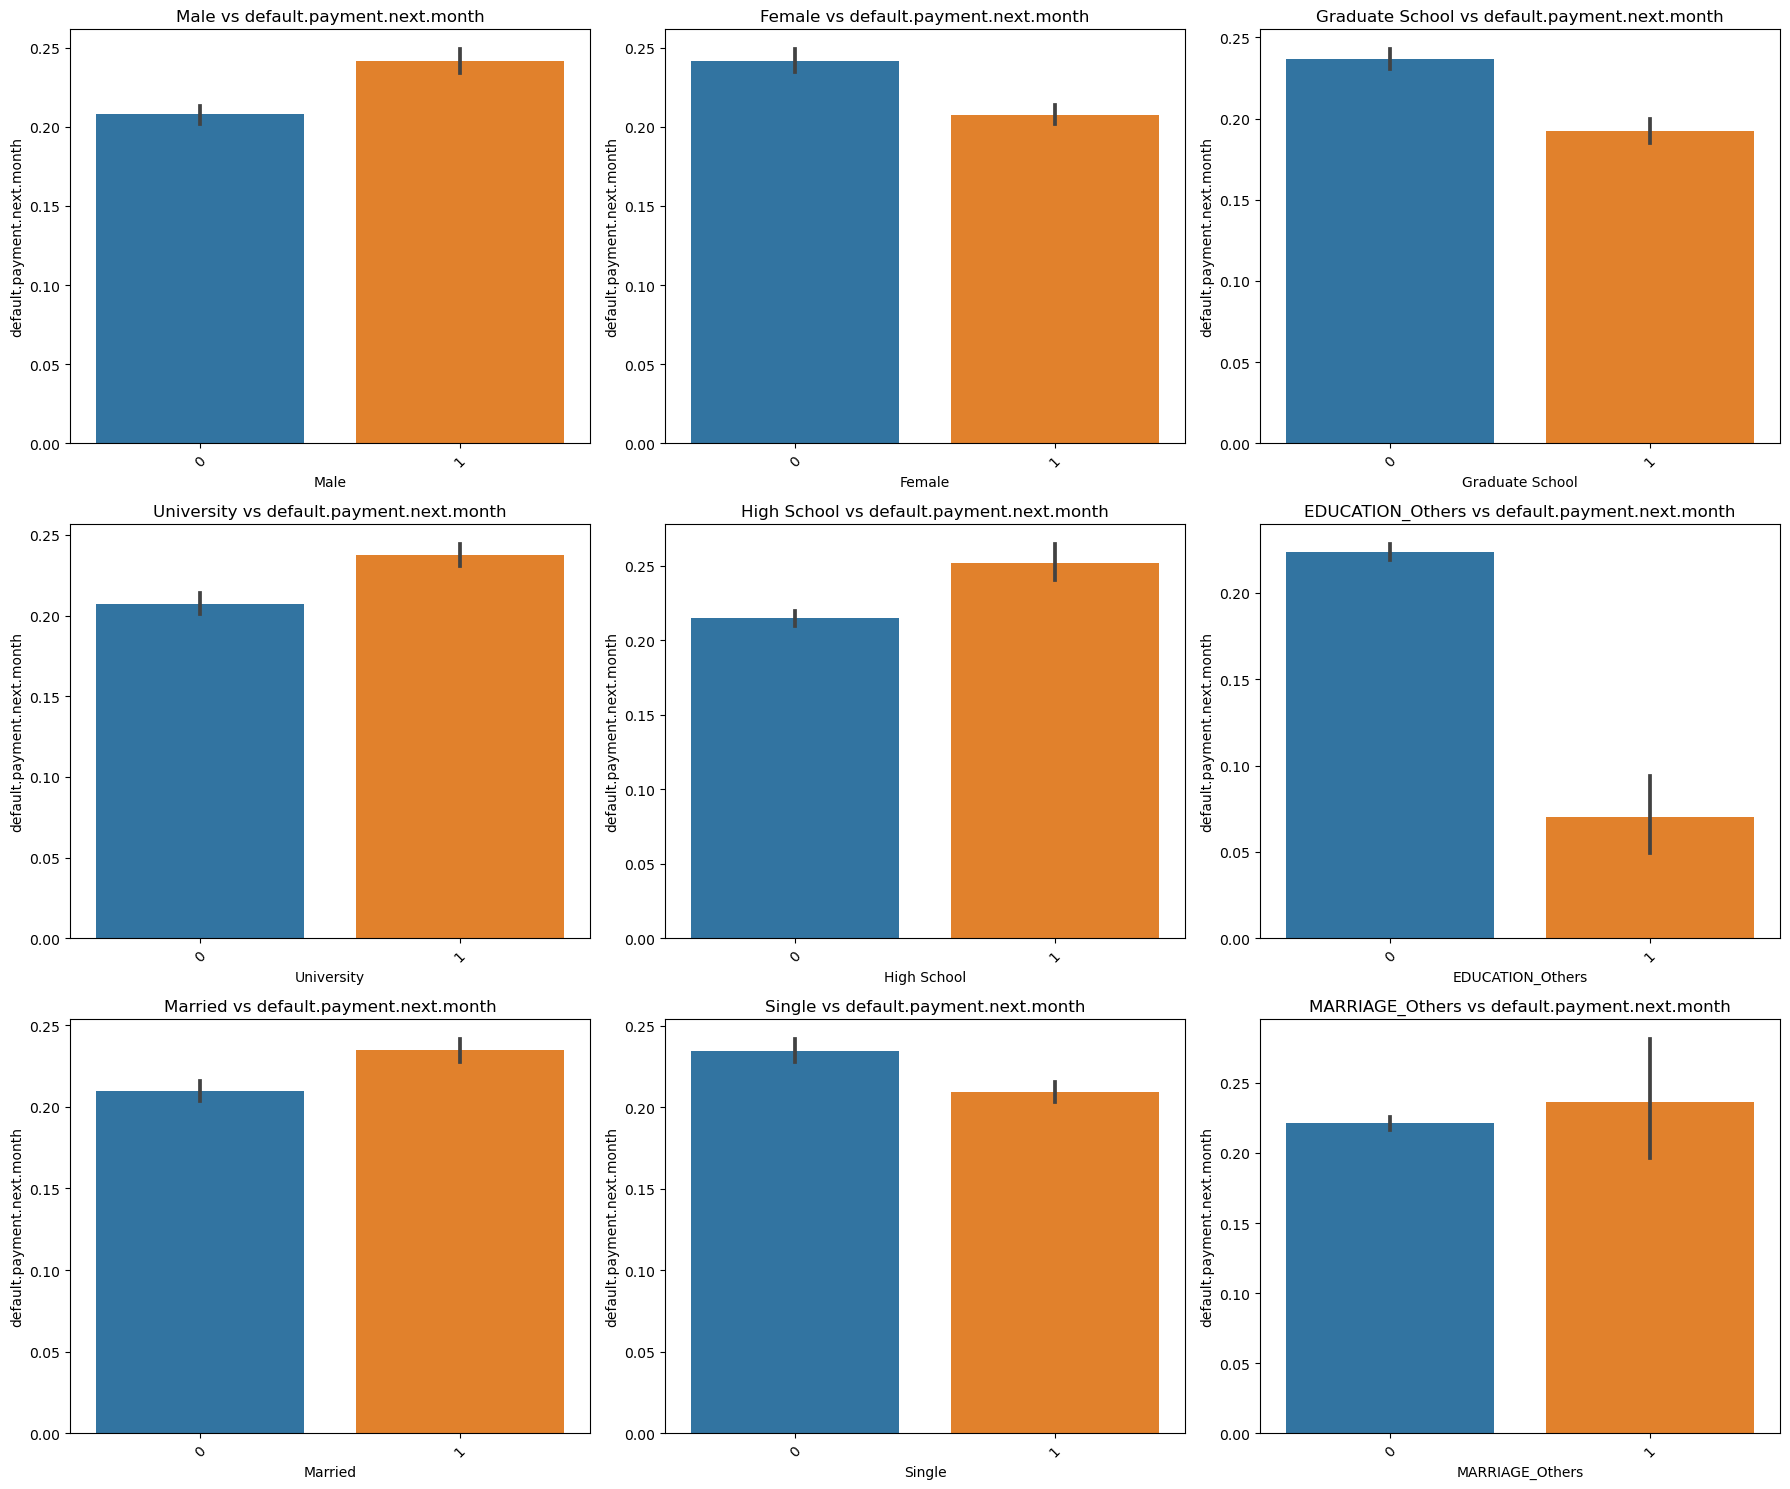

In [5]:
# Define categorical columns and target column
categorical_cols = ['Male', 'Female', 'Graduate School', 'University', 'High School', 'EDUCATION_Others', 'Married', 'Single', 'MARRIAGE_Others']
target_col = 'default.payment.next.month'

# Create a grid of subplots for all categorical variables
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot bar charts for each categorical variable vs target variable
for i, col in enumerate(categorical_cols):
    sns.barplot(x=col, y=target_col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs {target_col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_col)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Key Findings:
1. Default rates are generally higher for those who defaulted compared to those who didn't.
2. Females and high school graduates have slightly higher default rates.
3. Graduate school attendees who defaulted have a lower default rate, which is unusual.
4. Individuals with "other" forms of education who defaulted have a significantly lower default rate.
5. Married and single individuals have similar default rates, but those in the "others" marital category have a higher default rate if they defaulted.
## Summary:
- The visualization highlights demographic differences in default rates, showing that:
- Females and high school graduates are more likely to default
- Graduate school attendees are less likely to default
- Individuals with "other" forms of education are less likely to default
- Marital status has a minimal impact on default rates, except for those in the "others" category.


# EDA - Numerical Variables

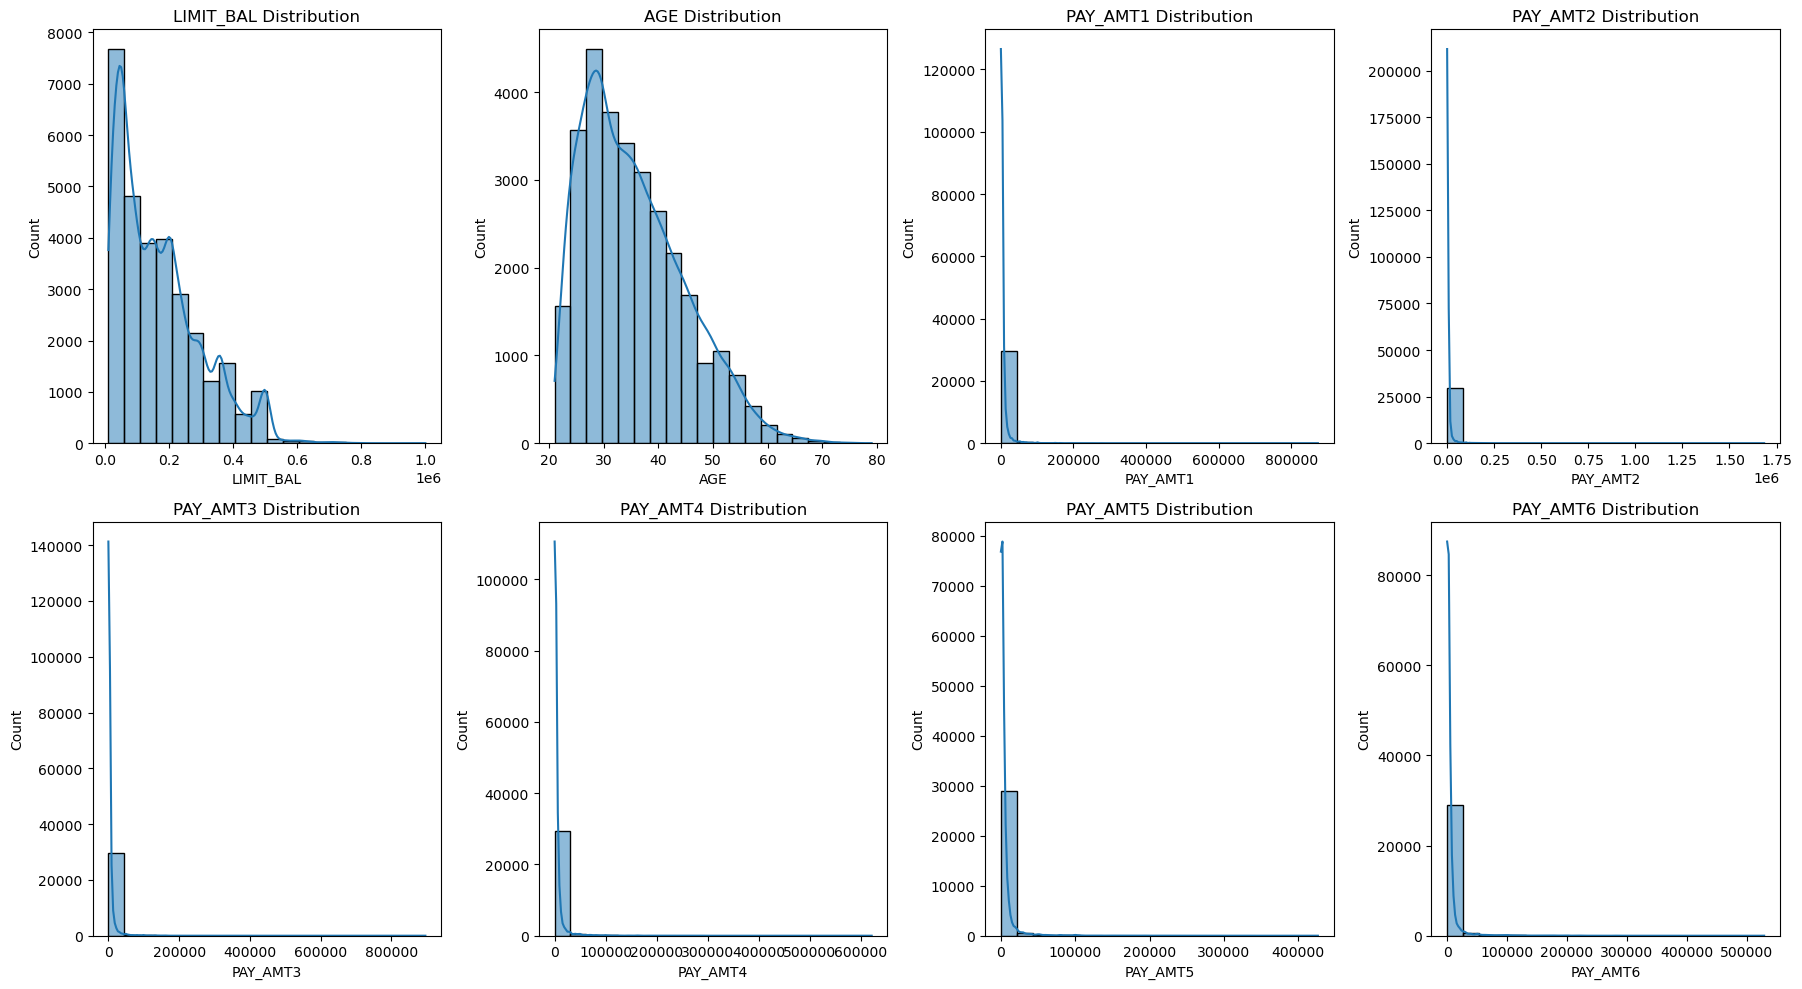

In [8]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Create a grid of subplots for all numeric variables
fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numeric variable
for i, col in enumerate(numerical_cols):
    # Convert inf values to NaN
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    # Plot histogram
    sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Key Findings:
1. Credit limits (LIMIT_BAL) are mostly below 200,000, with a few outliers up to 1,000,000.
2. Age (AGE) distribution is roughly normal, peaking around 30 years old, indicating a younger demographic.
3. All six payment amounts (PAY_AMT1 to PAY_AMT6) have highly right-skewed distributions, meaning:
   - Most payments are low (0-50,000)
   - A few outliers are extremely high (up to 1,750,000)
## Summary:
The histograms show that:
- Credit limits are generally low, with a few high outliers
- The age distribution is normal, peaking at 30 years old
- Payment amounts are mostly low, but with significant outliers, indicating varying payment behaviors.

# Statistical Analysis

In [11]:
# Descriptive statistics for numerical variables
print("\nDescriptive statistics:")
df.describe()


Descriptive statistics for numerical variables:


,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,default.payment.next.month,Male,Female,Graduate School,University,High School,EDUCATION_Others,Married,Single,MARRIAGE_Others
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,...,0.221200,0.396267,0.603733,0.352833,0.467667,0.163900,0.015600,0.455300,0.532133,0.012567
std,129747.661567,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,...,0.415062,0.489129,0.489129,0.477859,0.498962,0.370191,0.123924,0.498006,0.498975,0.111396
min,10000.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Interpretation for Descriptive Statistics
### Numerical Variables:
- The average credit limit (LIMIT_BAL) is approximately 167,484 units.
- The average age (AGE) of customers is 35.49 years.
- Payment statuses (PAY_1 to PAY_6) indicate that customers were mostly on time or had minor delays in their payments.
- The average bill amounts (BILL_AMT1 to BILL_AMT6) range from 49,179 to 51,223.
- The average payment amounts (PAY_AMT1 to PAY_AMT6) range from 4,799 to 5,215.
- Approximately 22.12% of customers defaulted on their payment in the following month (default.payment.next.month).
### Categorical Variables:
- 39.63% of customers are male (sex_male).
- 16.39% have a high school education (education_high_school).
- 1.56% have other forms of education (education_others).
- 46.77% have university-level education (education_university).
- 1.26% fall into other marital categories (marriage_others).
- 53.21% are single (marriage_single).

These statistics provide a snapshot of the dataset's central tendency, dispersion, and shape, helping us understand the distribution of financial and demographic variables among the 30,000 customers.

## Chi-Squared Test

- This test is best suitable for observing independence between each categorical variable and the target variable. 
- The test determines whether there is a significant association between the variables. 
- The p-values are stored in a list, and columns with p-values less than 0.05 are considered significant.

Chi-Squared Test for
Male: p-value = 4.944678999412026e-12
Female: p-value = 4.944678999412044e-12
Graduate School: p-value = 6.951248813626062e-19
University: p-value = 2.930923420635849e-10
High School: p-value = 2.2239759800771934e-08
EDUCATION_Others: p-value = 3.843987162559675e-15
Married: p-value = 2.7017310027696824e-07
Single: p-value = 1.2265522038142737e-07
MARRIAGE_Others: p-value = 0.5236017153089884


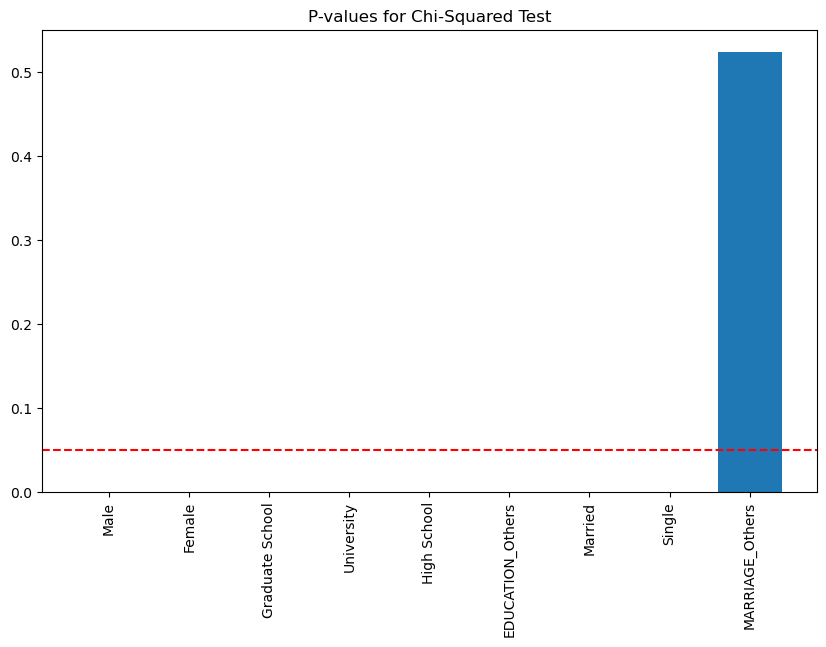

Significant columns: ['Male', 'Female', 'Graduate School', 'University', 'High School', 'EDUCATION_Others', 'Married', 'Single']


In [9]:
p_values = []
significant_cols = []
print(f'Chi-Squared Test for')
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'{col}: p-value = {p}')
    p_values.append(p)
    if p < 0.05:
        significant_cols.append(col)

plt.figure(figsize=(10, 6))
plt.bar(range(len(p_values)), p_values)
plt.xticks(range(len(p_values)), categorical_cols, rotation=90)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.title('P-values for Chi-Squared Test')
plt.show()

print('Significant columns:', significant_cols)

## Logistic Regression

In the logistic regression summary, 
- you can look for the coefficients, p-values, and
- odds ratios to determine which numerical features are significant.
- The p-values will indicate the significance of each feature, and the odds ratios will indicate the change in the odds of the target variable for a one-unit change in the feature.

In [13]:
# Add a constant term for the intercept
X = sm.add_constant(df[numerical_cols])

# Fit the logistic regression model
model = sm.Logit(df[target_col], X).fit()

# Print the summary statistics
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.510716
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29991
Method:                                   MLE   Df Model:                            8
Date:                        Sun, 26 May 2024   Pseudo R-squ.:                 0.03351
Time:                                17:17:18   Log-Likelihood:                -15321.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                5.006e-224
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9985      0.056    -17.799 

# Interpretation for Statistical Analysis
Based on the logistic regression results, the following predictors have statistically significant coefficients:
1. LIMIT_BAL (p-value = 0.000)
2. AGE (p-value = 0.000)
3. PAY_AMT1 (p-value = 0.000)
4. PAY_AMT2 (p-value = 0.000)
5. PAY_AMT3 (p-value = 0.005)
6. PAY_AMT4 (p-value = 0.002)
7. PAY_AMT5 (p-value = 0.021)

These predictors have coefficients that are significantly different from zero, indicating that they have a significant impact on the likelihood of defaulting on a credit card payment.

Note that PAY_AMT6 has a p-value of 0.142, which is greater than the typical significance level of 0.05, indicating that it is not a statistically significant predictor.

The coefficients of the significant predictors indicate the change in the odds of defaulting on a credit card payment associated with a one-unit change in the predictor while controlling for the other predictors in the model.

# Interpretation for Hypothesis Testing

Regarding hypothesis testing, the null hypothesis assumes that all coefficients are equal to zero, indicating no impact of the predictors on the probability of default. However, since some predictors have significant coefficients, 
### We reject the null hypothesis. 

Therefore, at least one of the factors (credit limits, history of late payments) significantly impacts the probability of default, supporting the alternative hypothesis. 

This implies that demographic factors alone may not be sufficient to predict default probability, as financial variables like credit limits and payment amounts also play a crucial role.

### Checking if the dataset is balanced or not.
We first examined the distribution of the target variable to understand the number of instances where default payment occurred (1) and where it did not occur (0). This provides insights into the class distribution within the dataset.

Understanding the balance of the dataset is crucial for building a robust predictive model. Imbalanced datasets, where one class is significantly more prevalent than the other, can lead to biased models that favor the majority class. By examining the distribution of the target variable, we can identify any potential class imbalances and take appropriate steps to address them, such as using resampling techniques or adjusting the model's performance metrics.


Distribution of the target variable:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64


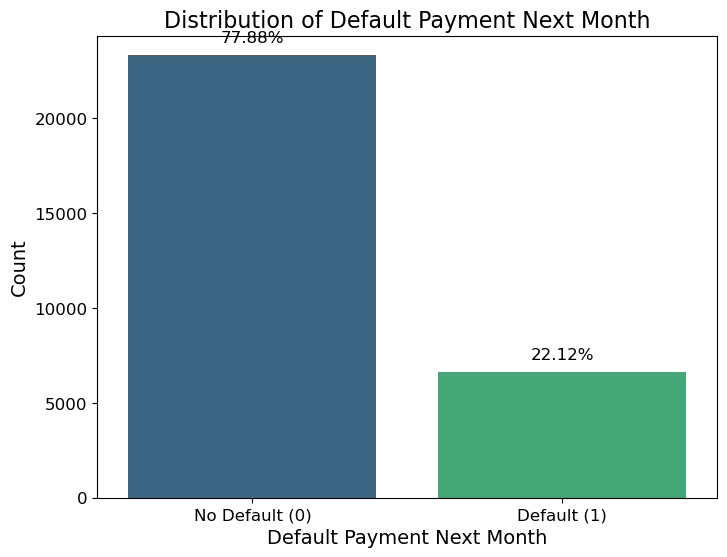

In [14]:
# Distribution of the target variable
print("\nDistribution of the target variable:")
print(df['default.payment.next.month'].value_counts())

# Calculate the counts and percentages
counts = df['default.payment.next.month'].value_counts()
total_samples = len(df)
percentages = counts / total_samples * 100

# Set up the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts, palette='viridis')

# Annotate the bars with the percentages
for i in range(len(counts)):
    plt.text(i, counts[i] + 500, f'{percentages[i]:.2f}%', ha='center', va='bottom', fontsize=12)

# Customize the plot
plt.title('Distribution of Default Payment Next Month', fontsize=16)
plt.xlabel('Default Payment Next Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['No Default (0)', 'Default (1)'], fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 1000)  # Adjust the y-axis limit for better visibility of annotations

# Show the plot
plt.show()

In [15]:
X = df.drop(['default.payment.next.month'],axis=1)
y = df['default.payment.next.month']

In [16]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_resampled)

We used SMOTE to handle the class imbalance issue. The reason We used PCA (Principal Component Analysis) afterward is for dimensionality reduction.
Here's why:
- Feature correlation: Many financial features are correlated, and PCA helps to reduce redundancy by identifying the most important features.
- Noise reduction: PCA can help filter out noise and irrelevant information, leading to a more robust model.
- Improved model performance: By reducing the dimensionality, PCA can improve the performance of some machine learning algorithms, especially those that are sensitive to the curse of dimensionality.
- Visualization: With fewer features, visualization and interpretation of results become easier.

In this specific case, we set n_components=0.95, which means PCA will retain about 95% of the original data's variance. This helps to strike a balance between dimensionality reduction and retaining important information.

In [17]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_resampled, test_size=0.2, random_state=42)

In [20]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Hyper-parameter Tuning
print("Hyper-parameter Tuning:")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Using the best parameters for training
classifier = RandomForestClassifier(**best_params, random_state=42)
classifier.fit(X_train, y_train)

# Cross-validation scores
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10)

# Evaluation
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Hyper-parameter Tuning:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4664
           1       0.84      0.84      0.84      4682

    accuracy                           0.84      9346
   macro avg       0.84      0.84      0.84      9346
weighted avg       0.84      0.84      0.84      9346

[[3929  735]
 [ 750 3932]]


In [22]:
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

y_pred_xgb = xgb_classifier.predict(X_test)

# Cross-validation scores
cv_scores_xgb = cross_val_score(xgb_classifier, X_train, y_train, cv=10)

print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      4664
           1       0.77      0.74      0.76      4682

    accuracy                           0.76      9346
   macro avg       0.76      0.76      0.76      9346
weighted avg       0.76      0.76      0.76      9346

[[3640 1024]
 [1219 3463]]


In [23]:
soft_voting_classifier = VotingClassifier(estimators=[('rf', classifier), ('xgb', xgb_classifier)], voting='soft', weights=[1, 1])
soft_voting_classifier.fit(X_train, y_train)

y_pred_soft = soft_voting_classifier.predict(X_test)

# Cross-validation scores
soft_cv_scores = cross_val_score(soft_voting_classifier, X_train, y_train, cv=10)

print(classification_report(y_test, y_pred_soft))
print(confusion_matrix(y_test, y_pred_soft))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4664
           1       0.82      0.80      0.81      4682

    accuracy                           0.81      9346
   macro avg       0.81      0.81      0.81      9346
weighted avg       0.81      0.81      0.81      9346

[[3822  842]
 [ 943 3739]]


In [24]:
hard_voting_classifier = VotingClassifier(estimators=[('rf', classifier), ('xgb', xgb_classifier)], voting='hard')
hard_voting_classifier.fit(X_train, y_train)

y_pred_hard = hard_voting_classifier.predict(X_test)

# Cross-validation scores
hard_cv_scores = cross_val_score(hard_voting_classifier, X_train, y_train, cv=10)

print(classification_report(y_test, y_pred_hard))
print(confusion_matrix(y_test, y_pred_hard))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      4664
           1       0.84      0.71      0.77      4682

    accuracy                           0.79      9346
   macro avg       0.80      0.79      0.79      9346
weighted avg       0.80      0.79      0.79      9346

[[4045  619]
 [1344 3338]]


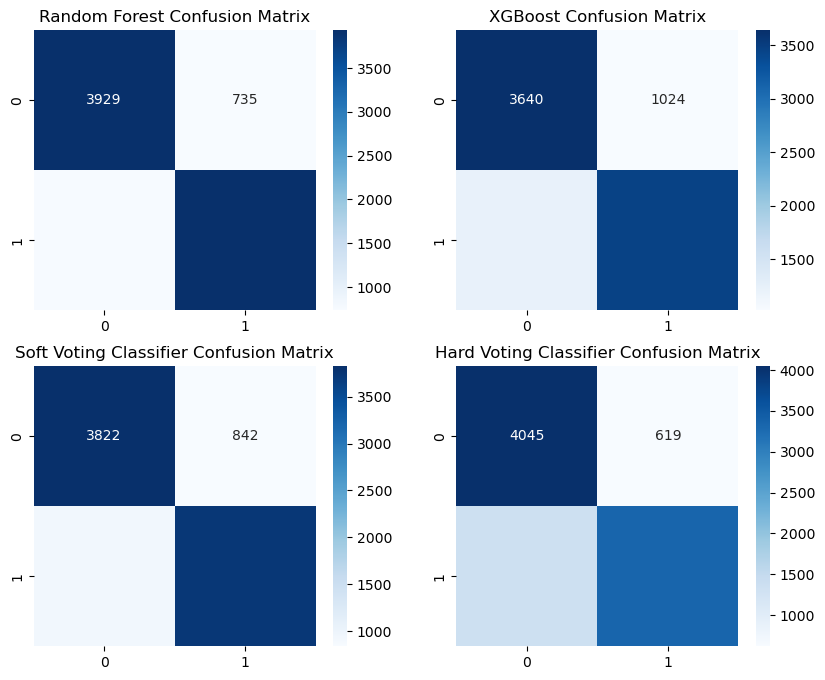

In [25]:
# Create a figure and axis object
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Confusion Matrix Heatmap for Random Forest
axs[0, 0].set_title('Random Forest Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', ax=axs[0, 0])

# Confusion Matrix Heatmap for XGBoost
axs[0, 1].set_title('XGBoost Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, cmap='Blues', fmt='g', ax=axs[0, 1])

# Confusion Matrix Heatmap for Soft Voting Classifier
axs[1, 0].set_title('Soft Voting Classifier Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_soft), annot=True, cmap='Blues', fmt='g', ax=axs[1, 0])

# Confusion Matrix Heatmap for Hard Voting Classifier
axs[1, 1].set_title('Hard Voting Classifier Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_hard), annot=True, cmap='Blues', fmt='g', ax=axs[1, 1])


# Show the plot
plt.show()

In [26]:
# Compare accuracy
accuracy_list = [
    ["Model", "Accuracy"],
    ["Random Forest", accuracy_score(y_test, y_pred)],
    ["XGBoost", accuracy_score(y_test, y_pred_xgb)],
    ["Soft Voting Classifier", accuracy_score(y_test, y_pred_soft)],
    ["Hard Voting Classifier", accuracy_score(y_test, y_pred_hard)],
]

# Compare F1-score
f1_list = [
    ["Model", "F1-score"],
    ["Random Forest", f1_score(y_test, y_pred, average='weighted')],
    ["XGBoost", f1_score(y_test, y_pred_xgb, average='weighted')],
    ["Soft Voting Classifier", f1_score(y_test, y_pred_soft, average='weighted')],
    ["Hard Voting Classifier", f1_score(y_test, y_pred_hard, average='weighted')],
]

# Compare cv-scores
cv_list = [
    ["Model", "cv_scores"],
    ["Random Forest", cv_scores],
    ["XGBoost", cv_scores_xgb],
    ["Soft Voting Classifier", soft_cv_scores],
    ["Hard Voting Classifier", hard_cv_scores],
]

print(tabulate(accuracy_list, headers="firstrow", tablefmt="fancy_grid"))
print(tabulate(f1_list, headers="firstrow", tablefmt="fancy_grid"))
print(tabulate(cv_list, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════════════╤════════════╕
│ Model                  │   Accuracy │
╞════════════════════════╪════════════╡
│ Random Forest          │   0.841108 │
├────────────────────────┼────────────┤
│ XGBoost                │   0.760004 │
├────────────────────────┼────────────┤
│ Soft Voting Classifier │   0.809009 │
├────────────────────────┼────────────┤
│ Hard Voting Classifier │   0.789964 │
╘════════════════════════╧════════════╛
╒════════════════════════╤════════════╕
│ Model                  │   F1-score │
╞════════════════════════╪════════════╡
│ Random Forest          │   0.841109 │
├────────────────────────┼────────────┤
│ XGBoost                │   0.759909 │
├────────────────────────┼────────────┤
│ Soft Voting Classifier │   0.808991 │
├────────────────────────┼────────────┤
│ Hard Voting Classifier │   0.788724 │
╘════════════════════════╧════════════╛
╒════════════════════════╤════════════════════════════════════════════════════════════════════╕
│ Model                 

## Overall Performance:
1. Random Forest is the top-performing model, with an accuracy of 84% and an F1-score of 84%. It has a high and consistent performance across folds, indicating robustness and reliability.

2. Soft Voting Classifier is the second-best model, with an accuracy of 80.73% and an F1-score of 80.73%. It also has a high and consistent performance across folds, indicating good performance and robustness.

3. Hard Voting Classifier has a lower accuracy (78.94%) and F1-score (78.81%), with slightly inconsistent performance across folds. This indicates that it may need further tuning or hyperparameter optimization to improve its performance.

4. XGBoost has the lowest accuracy (76.00%) and F1-score (75.99%), with slightly inconsistent performance across folds. This indicates that it may need significant tuning or hyperparameter optimization to improve its performance.

# Conclusion:
This study aimed to investigate the factors affecting credit card default payments. The results of the statistical analysis and hypothesis testing suggest that:
- Demographic factors such as gender, education level, and marital status have a significant impact on credit card default payments.
- Credit limits and payment amounts are also significant predictors of default payments.
- The results of the hypothesis testing support the alternative hypothesis, indicating that at least one of the factors (credit limits, history of late payments, or demographic factors) significantly impacts the probability of default.

## The model results show that:
- Random Forest is the top-performing model, followed by Soft Voting Classifier, Hard Voting Classifier, and XGBoost.
- Random Forest and Soft Voting Classifier have high and consistent accuracy across folds, while Hard Voting Classifier and XGBoost have lower and slightly inconsistent accuracy.

Overall, the findings suggest that a combination of demographic and financial factors contributes to credit card default payments. The results can be used to develop targeted strategies for credit card issuers to reduce default rates and improve risk assessment.

## Recommendations:
- Credit card issuers should consider demographic factors such as gender, education level, and marital status when assessing credit risk.
- Credit limits and payment amounts should be carefully monitored and adjusted to reduce the likelihood of default.
- Random Forest and Soft Voting Classifier models can be used to predict credit card default payments with high accuracy.
Further research can be conducted to explore additional factors and improve the accuracy of credit risk assessment models.